In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [7]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Metal device set to: Apple M1
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/ac652c60_nohash_1.wav', shape=(), dtype=string)


2021-11-23 20:30:08.679119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-23 20:30:08.679239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [9]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
    return parts[-2] 

In [11]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

# The imputation

In [13]:
### new new 
def spectro_impute(spectrogram):
    log_spec = tf.math.log(tf.transpose(tf.squeeze(spectrogram)))
    #new_spec = log_spec[~tf.math.is_inf(log_spec)]

    FUDGE = 0.15

    
    
    #get where there are missing columns 
    
    mask = tf.math.reduce_any(tf.math.is_inf(log_spec), axis=0, keepdims=False, name=None)

    mask.set_shape([None])

    #get the non-missing columns
    newspec = tf.boolean_mask(log_spec,~mask,axis=1)
    
    #take their means

    means = tf.math.reduce_mean(newspec,axis=1,keepdims=True)
    stdevs = tf.math.reduce_std(newspec,axis=1,keepdims=True)


    #now need to generate big random tensor 

    #first generate a big standard normal one, then multiply rows by std and add means


    big_random = tf.random.normal(tf.shape(log_spec))

    big_random = big_random*FUDGE*stdevs
    big_random = big_random + means

    #use the mask to replace missing values with random ones

    final_spec = tf.where(tf.math.is_inf(log_spec),big_random,log_spec)


    return tf.transpose(final_spec)
    #if you want, you can instead use the exponential of this - doesn't seem to make much difference.
    #return tf.transpose(tf.math.exp(final_spec))

## Test out the imputation 

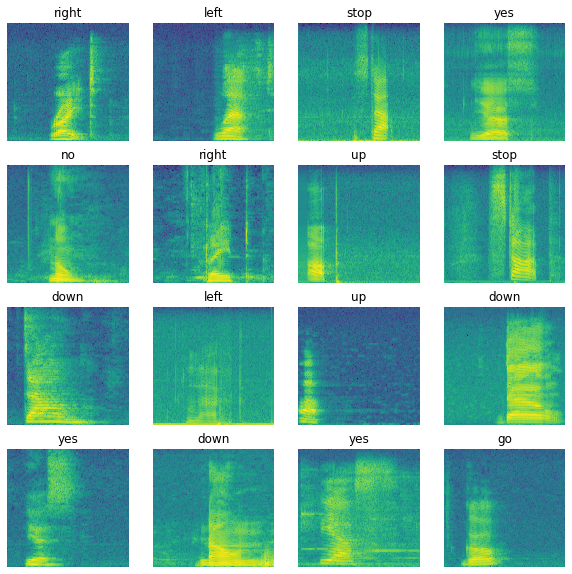

In [19]:
#doesn't work yet
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(imputed_spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    #tf_imputed_log_spec = tf.math.exp(spectro_impute(spectrogram))
    #tf_imputed_log_spec = spectro_impute(spectrogram)
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')
  
plt.show()

In [14]:
def get_imputed_spectrogram(waveform):
  # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectro_impute(spectrogram)
    tf.cast(spectrogram, tf.float32)
  #spectrogram = tf.abs(spectrogram)
    return spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_imputed_spectrogram(waveform)
print(waveform)
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
#print('Audio playback')
#display.display(display.Audio(waveform, rate=16000))


2021-11-23 20:30:54.670705: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-23 20:30:54.671805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(
[-1.5258789e-04 -1.2207031e-04 -9.1552734e-05 ...  9.1552734e-05
  9.1552734e-05  1.8310547e-04], shape=(16000,), dtype=float32)
Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129)


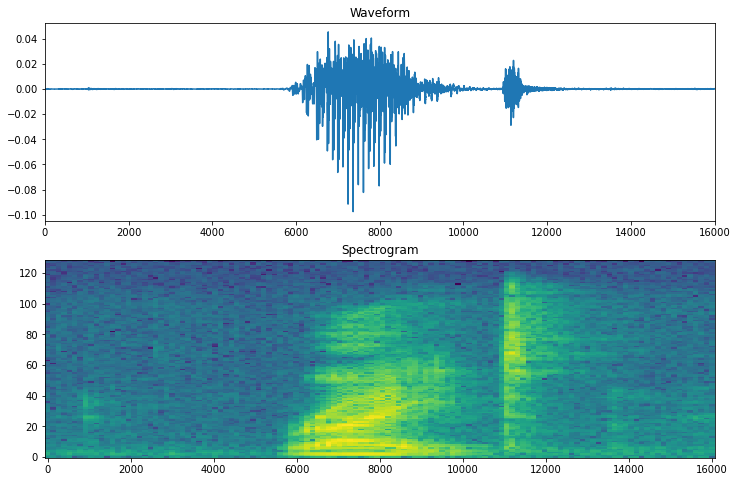

In [16]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). A epsilon is added to avoid log of zero.
  log_spec = spectrogram.T
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [27]:
def get_imputed_spectrogram_and_label_id(audio, label):
    spectrogram = get_imputed_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    #have to do this because of some bug in tensorflow -_-
    
    spectrogram.set_shape((124,129,1))
    
    
    
    ##I THINK THIS WAS CULPRIT - fixed by updating everything
    label_id = tf.argmax(label == commands)
    
    
    return spectrogram, label_id

In [28]:
##ERROR HERE

#imputed_spectrogram_ds = waveform_ds.map(get_imputed_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
imputed_spectrogram_ds = waveform_ds.map(get_imputed_spectrogram_and_label_id)

In [20]:
def imputed_preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_imputed_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [21]:
imputed_train_ds = imputed_spectrogram_ds
imputed_val_ds = imputed_preprocess_dataset(val_files)
imputed_test_ds = imputed_preprocess_dataset(test_files)

In [22]:
batch_size = 64
imputed_train_ds = imputed_train_ds.batch(batch_size)
imputed_val_ds = imputed_val_ds.batch(batch_size)

In [23]:
imputed_train_ds = imputed_train_ds.cache().prefetch(AUTOTUNE)
imputed_val_ds = imputed_val_ds.cache().prefetch(AUTOTUNE)

In [46]:
for spectrogram, _ in imputed_spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

imp_norm_layer = preprocessing.Normalization()
imp_norm_layer.adapt(imputed_spectrogram_ds.map(lambda x, _: x))

imp_model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    imp_norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

imp_model.summary()

Input shape: (124, 129, 1)


2021-11-23 21:46:25.066511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-23 21:46:25.076609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [47]:
imp_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [48]:
EPOCHS = 40
imp_history = imp_model.fit(
    imputed_train_ds, 
    validation_data=imputed_val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=25),
)

Epoch 1/40
  4/100 [>.............................] - ETA: 1s - loss: 2.1318 - accuracy: 0.1562 

2021-11-23 21:47:06.946613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 2s 19ms/step - loss: 1.7270 - accuracy: 0.3416 - val_loss: 1.2580 - val_accuracy: 0.5600
Epoch 2/40
  1/100 [..............................] - ETA: 2s - loss: 1.3425 - accuracy: 0.4375

2021-11-23 21:47:08.752380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 2s 18ms/step - loss: 1.2070 - accuracy: 0.5481 - val_loss: 0.8605 - val_accuracy: 0.7100
Epoch 3/40
100/100 [==============================] - 2s 18ms/step - loss: 0.9218 - accuracy: 0.6591 - val_loss: 0.6989 - val_accuracy: 0.7537
Epoch 4/40
100/100 [==============================] - 2s 18ms/step - loss: 0.7453 - accuracy: 0.7237 - val_loss: 0.5694 - val_accuracy: 0.8000
Epoch 5/40
100/100 [==============================] - 2s 18ms/step - loss: 0.6281 - accuracy: 0.7723 - val_loss: 0.5268 - val_accuracy: 0.8212
Epoch 6/40
100/100 [==============================] - 2s 18ms/step - loss: 0.5459 - accuracy: 0.7997 - val_loss: 0.4591 - val_accuracy: 0.8413
Epoch 7/40
100/100 [==============================] - 2s 18ms/step - loss: 0.4914 - accuracy: 0.8161 - val_loss: 0.4524 - val_accuracy: 0.8400
Epoch 8/40
100/100 [==============================] - 2s 18ms/step - loss: 0.4322 - accuracy: 0.8422 - val_loss: 0.4317 - val_accuracy: 0.8550
Epoch 9/40

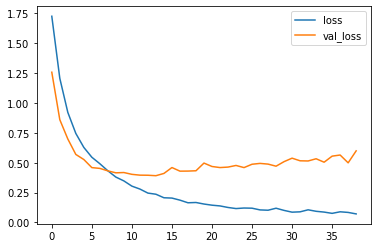

In [49]:
metrics = imp_history.history
plt.plot(imp_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [50]:
test_audio_imp = []
test_labels_imp = []

for audio, label in imputed_test_ds:
  test_audio_imp.append(audio.numpy())
  test_labels_imp.append(label.numpy())

test_audio_imp = np.array(test_audio_imp)
test_labels_imp = np.array(test_labels_imp)

In [51]:
y_pred_imp = np.argmax(imp_model.predict(test_audio_imp), axis=1)
y_true_imp = test_labels_imp

test_acc_imp = sum(y_pred_imp == y_true_imp) / len(y_true_imp)
print(f'Test set accuracy: {test_acc_imp:.00%}')

Test set accuracy: 86%


2021-11-23 21:48:50.461818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


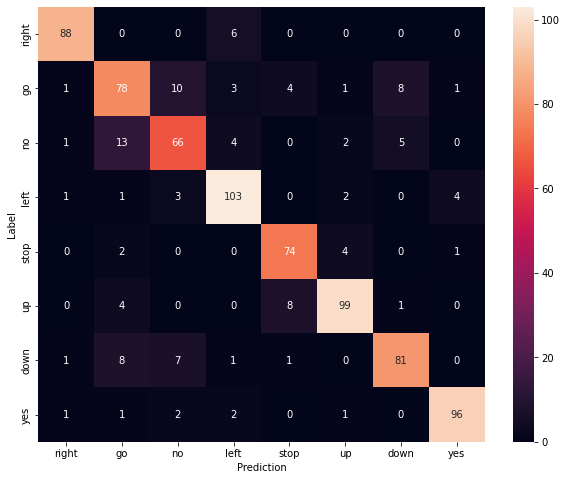

In [52]:
confusion_mtx_imp = tf.math.confusion_matrix(y_true_imp, y_pred_imp) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_imp, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

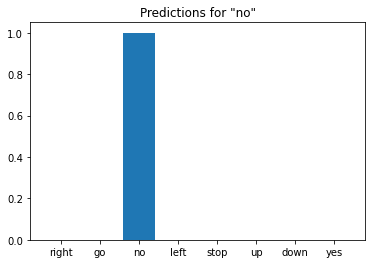

In [54]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = imputed_preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(2):
  prediction = imp_model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()